In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
# Attributes Information:

data_info = pd.read_csv("Data/NUSW-NB15_features.csv", encoding = "ISO-8859-1")
data_info

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [3]:
# Retrive Attribute Names

column_attributes = list (data_info['Name']) 
column_attributes

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'Sload',
 'Dload',
 'Spkts',
 'Dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'Sjit',
 'Djit',
 'Stime',
 'Ltime',
 'Sintpkt',
 'Dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat',
 'Label']

In [4]:
pd.set_option('display.max_column', 50)

In [5]:
# Read the data available in 4 csv files using temporary data frames

dataframe1 = pd.read_csv("Data/UNSW-NB15_1.csv",low_memory=False, header=None)
dataframe2 = pd.read_csv("Data/UNSW-NB15_2.csv", low_memory=False, header=None)
dataframe3 = pd.read_csv("Data/UNSW-NB15_3.csv", low_memory=False, header=None)
dataframe4 = pd.read_csv("Data/UNSW-NB15_4.csv",low_memory=False, header=None)

In [6]:
# Sample raw data

dataframe1[0:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0,0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0,0,0,7,9,1,1,1,1,1,NaN,0


In [7]:
# Name the columns of all data frame with attribute names in features.csv

df_list = [dataframe1,dataframe2,dataframe3,dataframe4]
for df in df_list:
    name = [v.lower() for k, v in enumerate(column_attributes)]
    df.columns = name

In [8]:
# sample result rows after renaming columns

dataframe1[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0,0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0,0,0,7,9,1,1,1,1,1,NaN,0


In [9]:
# Concat the 4 temporary data frames into one single data frame

dataset = pd.concat([dataframe1, dataframe2, dataframe3, dataframe4])
dataset.shape

(2540047, 49)

In [10]:
dataset[0:10]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0
5,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,29,0,0,-,43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,1421927414,1421927414,21.003,24.315000,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
6,59.166.0.6,2142,149.171.126.4,53,udp,CON,0.001134,132,164,31,29,0,0,dns,465608.46880,578483.25000,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,7,1,2,2,1,1,NaN,0
7,10.40.182.3,0,10.40.182.3,0,arp,INT,0.000000,46,0,0,0,0,0,-,0.00000,0.00000,1,0,0,0,0,0,46,0,0,0,0.000000,0.000000,1421927415,1421927415,0.000,0.000000,0.0,0.0,0.0,1,2,0.0,0.0,0,2,2,2,2,2,2,2,NaN,0
8,59.166.0.5,40726,149.171.126.6,53,udp,CON,0.001126,146,178,31,29,0,0,dns,518650.09380,632326.81250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927415,1421927415,0.018,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,7,3,1,1,1,1,NaN,0
9,59.166.0.7,12660,149.171.126.4,53,udp,CON,0.001167,132,164,31,29,0,0,dns,452442.15630,562125.06250,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927415,1421927415,0.018,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,7,2,1,1,1,1,NaN,0


In [11]:
dataset.describe(include='all')

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
count,2540047,2540047.0,2540047,2540047,2540047,2540047,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2540047,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,1.191902e+06,1.110168e+06,2540047,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,321283,2.540047e+06
unique,43,129124.0,47,64630,135,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN
top,59.166.0.4,1043.0,149.171.126.3,53,tcp,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,NaN
freq,197959,214363.0,197771,798968,1495074,1478689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1246397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1429879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215481,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.587916e-01,4.339600e+03,3.642759e+04,6.278197e+01,3.076681e+01,5.163921e+00,1.632944e+01,NaN,3.695645e+07,2.450861e+06,3.328884e+01,4.272664e+01,1.500887e+02,1.497459e+02,1.261701e+09,1.261766e+09,1.242536e+02,2.766719e+02,8.325318e-02,4.242118e+03,1.589037e+03,7.300755e+02,1.423261e+09,1.423261e+09,1.933225e+02,7.882476e+01,6.180475e-03,3.287595e-03,2.892880e-03,1.651544e-03,2.611546e-01,2.345856e-01,3.969940e-02,NaN,9.206988e+00,8.988958e+00,6.439103e+00,6.900986e+00,4.642139e+00,3.592729e+00,6.845886e+00,NaN,1.264870e-01
std,NaN,NaN,NaN,NaN,NaN,NaN,1.392493e+01,5.640599e+04,1.610960e+05,7.462277e+01,4.285089e+01,2.251707e+01,5.659474e+01,NaN,1.186043e+08,4.224863e+06,7.628388e+01,1.215020e+02,1.254824e+02,1.255438e+02,1.422027e+09,1.422139e+09,1.519162e+02,3.356166e+02,3.500045e-01,4.750053e+04,1.691036e+04,3.438558e+03,1.134449e+06,1.134448e+06,2.779163e+03,1.433191e+03,4.615863e-02,2.593570e-02,2.394668e-02,4.060563e-02,6.830974e-01,7.940924e-01,1.996589e-01,NaN,1.083676e+01,1.082249e+01,8.162034e+00,8.205062e+00,8.477579e+00,6.174445e+00,1.125828e+01,NaN,3.323975e-01
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421927e+09,1.421927e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.037000e-03,2.000000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,NaN,1.353963e+05,1.191594e+04,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,6.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421952e+09,1.421952e+09,9.000000e-03,6.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.586100e-02,1.470000e+03,1.820000e+03,3.100000e+01,2.900000e+01

In [12]:
# Delete temporary data frames

del dataframe1
del dataframe2
del dataframe3
del dataframe4

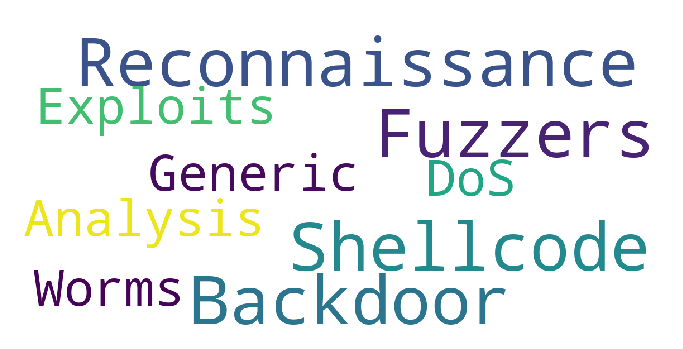

In [49]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):

    attack_catgs = data['attack_cat'].dropna().unique()


    for i in range(len(attack_catgs)):
        attack_catgs[i] = attack_catgs[i].strip()

    text = " ".join(str(item) for item in attack_catgs)
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(dataset)

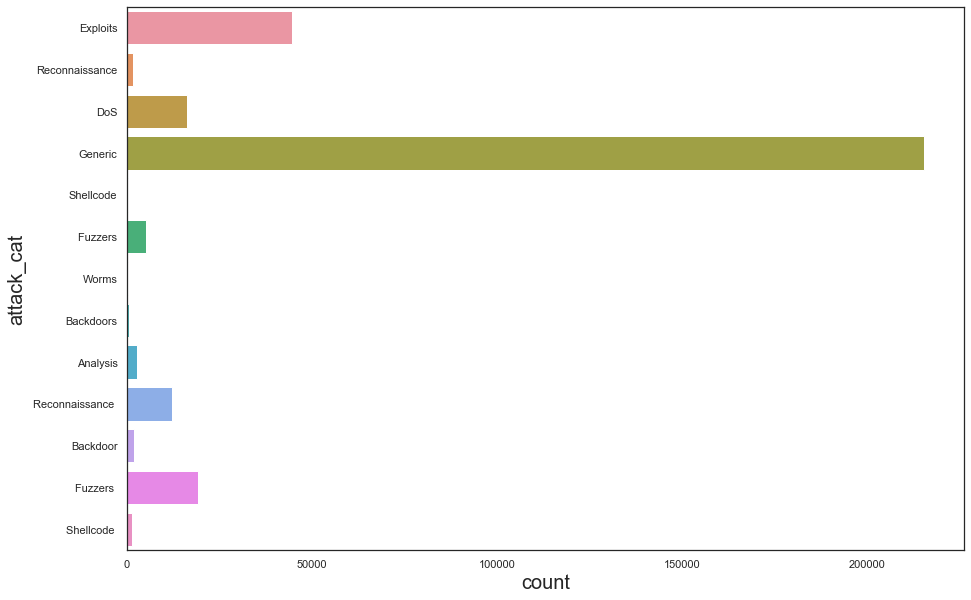

In [72]:

def plot_attack_category(data):
    sns.set(rc={'figure.figsize':(15,10),"font.size":70,"axes.titlesize":40,"axes.labelsize":20},style="white")
    catg_plot = sns.countplot(y='attack_cat',data = data)
    
plot_attack_category(dataset)  

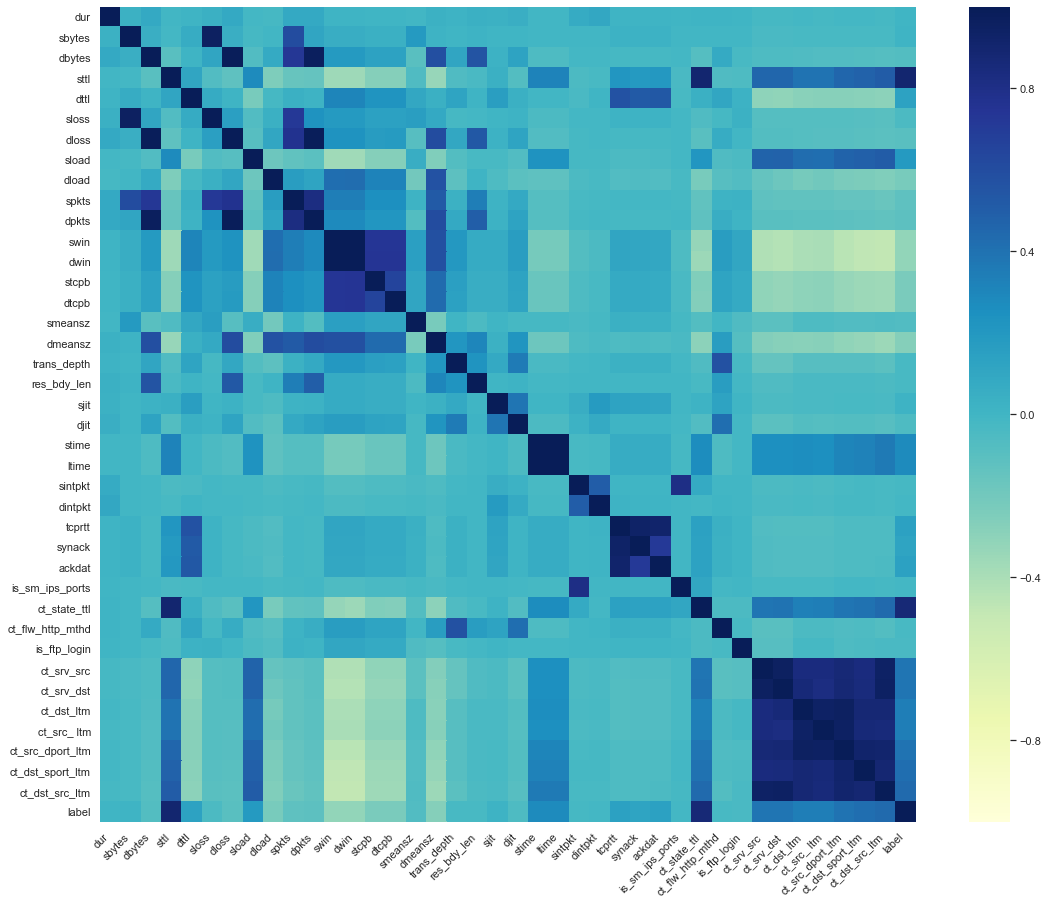

In [67]:
def plot_correlation(data):
    corr = data.corr()
    plt.figure(figsize=(19, 15))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,square=True,annot_kws={"size":12},cmap="YlGnBu")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize = 30)
    
plot_correlation(dataset)

In [74]:
# Get columns that have null values

dataset.columns[dataset.isna().any()].tolist()

['ct_flw_http_mthd', 'is_ftp_login', 'attack_cat']

In [75]:
# Handling Null values 

dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace(np.nan,'normal', regex=True)
dataset.loc[:,'ct_flw_http_mthd'] = dataset.loc[:,'ct_flw_http_mthd'].replace(np.nan,0, regex=True)
dataset.loc[:,'is_ftp_login'] = dataset.loc[:,'is_ftp_login'].replace(np.nan,0, regex=True)

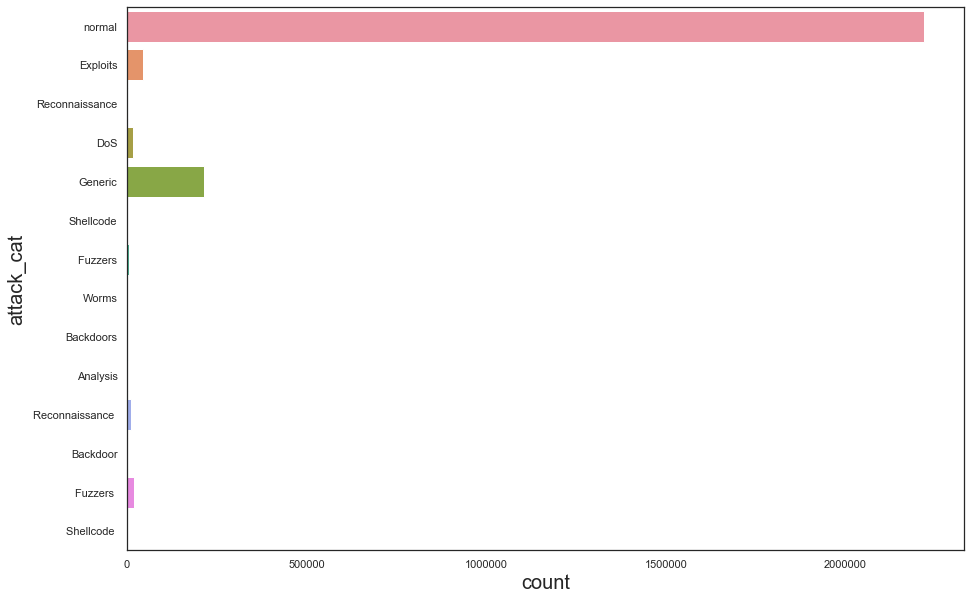

In [76]:
plot_attack_category(dataset)

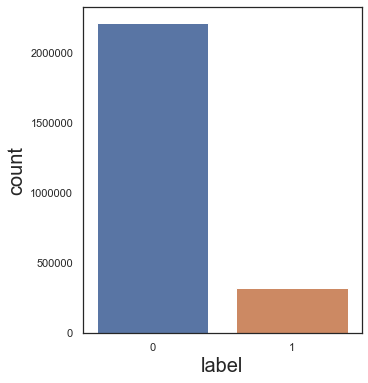

In [81]:
def plot_attack_label(data):
    sns.set(rc={'figure.figsize':(5,6),"font.size":70,"axes.titlesize":40,"axes.labelsize":20},style="white")
    catg_plot = sns.countplot(x='label',data = data)
plot_attack_label(dataset)

In [54]:
# # Drop unwanted columns from the dataset

# dataset.drop(['srcip',
#  'sport',
#  'dstip',
#  'dsport',
#  'stime',
#  'ltime'], axis = 1) 

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,udp,CON,0.001055,132,164,31,29,0,0,dns,5.004739e+05,6.218009e+05,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,3,7,1,3,1,1,1,normal,0
1,udp,CON,0.036133,528,304,31,29,0,0,-,8.767609e+04,5.048017e+04,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,7.005000,7.564333,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,2,4,2,3,1,1,2,normal,0
2,udp,CON,0.001119,146,178,31,29,0,0,dns,5.218945e+05,6.362824e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,12,8,1,2,2,1,1,normal,0
3,udp,CON,0.001209,132,164,31,29,0,0,dns,4.367246e+05,5.425972e+05,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,0.043000,0.014000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,6,9,1,1,1,1,1,normal,0
4,udp,CON,0.001169,146,178,31,29,0,0,dns,4.995722e+05,6.090676e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,0.005000,0.003000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,7,9,1,1,1,1,1,normal,0
5,udp,CON,0.078339,568,312,31,29,0,0,-,4.350323e+04,2.389614e+04,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,21.003000,24.315000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,2,4,2,3,1,1,2,normal,0
6,udp,CON,0.001134,132,164,31,29,0,0,dns,4.656085e+05,5.784832e+05,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,12,7,1,2,2,1,1,normal,0
7,arp,INT,0.000000,46,0,0,0,0,0,-,0.000000e+00,0.000000e+00,1,0,0,0,0,0,46,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,2,0.0,0.0,0,2,2,2,2,2,2,2,normal,0
8,udp,CON,0.001126,146,178,31,29,0,0,dns,5.186501e+05,6.323268e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,0.018000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,6,7,3,1,1,1,1,normal,0
9,udp,CON,0.001167,132,164,31,29,0,0,dns,4.524422e+05,5.621251e+05,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,0.018000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,6,7,2,1,1,1,1,normal,0


In [55]:
X_train = dataset.drop(['attack_cat', 'label'], axis = 1)
num_keys = X_train.select_dtypes(exclude=['object']).keys()

In [56]:
def log_transform(num_train_dataset):
    # print(num_train_dataset)
    ds = num_train_dataset.apply(lambda x: np.log(x + 1))
    return ds

In [57]:
from sklearn.preprocessing import MinMaxScaler
def min_max_scaler(transformed_dataset):
    ds = MinMaxScaler().fit_transform(transformed_dataset)
    return ds

In [58]:
log_transform_ds = []
log_transform_ds = log_transform(X_train[num_keys])
print(log_transform_ds)
min_max_scale = min_max_scaler(log_transform_ds)
print(min_max_scale)

                 dur     sbytes     dbytes      sttl      dttl     sloss  \
0       1.054444e-03   4.890349   5.105945  3.465736  3.401197  0.000000   
1       3.549551e-02   6.270988   5.720312  3.465736  3.401197  0.000000   
2       1.118374e-03   4.990433   5.187386  3.465736  3.401197  0.000000   
3       1.208270e-03   4.890349   5.105945  3.465736  3.401197  0.000000   
4       1.168317e-03   4.990433   5.187386  3.465736  3.401197  0.000000   
5       7.542189e-02   6.343880   5.746203  3.465736  3.401197  0.000000   
6       1.133358e-03   4.890349   5.105945  3.465736  3.401197  0.000000   
7       0.000000e+00   3.850148   0.000000  0.000000  0.000000  0.000000   
8       1.125367e-03   4.990433   5.187386  3.465736  3.401197  0.000000   
9       1.166320e-03   4.890349   5.105945  3.465736  3.401197  0.000000   
10      0.000000e+00   3.850148   0.000000  0.000000  0.000000  0.000000   
11      0.000000e+00   3.850148   0.000000  0.000000  0.000000  0.000000   
12      0.00

[[1.16114098e-04 2.96750557e-01 3.09442522e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.90872353e-03 3.80528927e-01 3.46675795e-01 ... 0.00000000e+00
  0.00000000e+00 1.14981184e-01]
 [1.23154049e-04 3.02823706e-01 3.14378161e-01 ... 1.14981184e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [2.19431362e-01 4.54936930e-01 4.63286387e-01 ... 1.14981184e-01
  1.18635908e-01 1.14981184e-01]
 [1.28116912e-01 4.95169869e-01 7.28468829e-01 ... 1.14981184e-01
  1.18635908e-01 1.14981184e-01]
 [7.31436552e-02 3.85588595e-01 3.94999251e-01 ... 1.14981184e-01
  1.18635908e-01 1.14981184e-01]]


In [ ]:
def compute_feature_importance(X,y):

    Build a classification task using 3 informative features
    X, y = make_classification(n_samples=1000,
                               n_features=10,
                               n_informative=3,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2,
                               random_state=0,
                               shuffle=False)

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()